In [ ]:
!pip install torchxrayvision

In [137]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchxrayvision as xrv
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler

from dataloader import *

In [138]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(224)])


d_covid19 = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",
                                   csvpath="covid-chestxray-dataset/metadata.csv",
                                   transform=transform)

d_nih = xrv.datasets.NIH_Dataset(imgpath="nih-dataset/subset-224",
                                 csvpath="nih-dataset/subset.csv")

#Final dataset
covid_dataset = CovidLandmarksDataset(csv_file='./final-dataset/metadata.csv',
                                           root_dir='./final-dataset/images/',
                                      model_type="detection",
                                     transform=transform)

{'ARDS': 0.0,
 'Bacterial Pneumonia': 0.0,
 'COVID-19': 1.0,
 'Chlamydophila': 0.0,
 'Fungal Pneumonia': 0.0,
 'Klebsiella': 0.0,
 'Legionella': 0.0,
 'MERS': 0.0,
 'No Finding': 0.0,
 'Pneumocystis': 0.0,
 'Pneumonia': 1.0,
 'SARS': 0.0,
 'Streptococcus': 0.0,
 'Viral Pneumonia': 1.0}

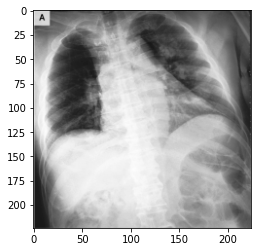

In [139]:
sample = d_covid19[0]
plt.imshow(sample["PA"][0], cmap="Greys_r");
dict(zip(d_covid19.pathologies,sample["lab"]))

In [140]:
d_nih

{'Atelectasis': {0.0: 63, 1.0: 10},
 'Cardiomegaly': {0.0: 72, 1.0: 1},
 'Consolidation': {0.0: 70, 1.0: 3},
 'Edema': {0.0: 73},
 'Effusion': {0.0: 63, 1.0: 10},
 'Emphysema': {0.0: 73},
 'Fibrosis': {0.0: 73},
 'Hernia': {0.0: 72, 1.0: 1},
 'Infiltration': {0.0: 54, 1.0: 19},
 'Mass': {0.0: 66, 1.0: 7},
 'Nodule': {0.0: 70, 1.0: 3},
 'Pleural_Thickening': {0.0: 73},
 'Pneumonia': {0.0: 73},
 'Pneumothorax': {0.0: 71, 1.0: 2}}


NIH_Dataset num_samples=73

In [141]:
batch_size = 5
validation_split = .2
shuffle_dataset = True
random_seed= 420

# Creating data indices for training and validation splits:
dataset_size = len(covid_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [142]:
positives = 0
balanced_val_indices = []
for idx in val_indices:
    sample = covid_dataset[idx]
    if sample['gt_label'] == 1:
        positives += 1

samples_left = [positives, positives]
for idx in val_indices:
    sample = covid_dataset[idx]
    l = int(sample['gt_label'])
    if samples_left[l] > 0:
        samples_left[l] -= 1
        balanced_val_indices.append(idx)

len(balanced_val_indices)

42

In [143]:
label_cnt = [0, 0]
for idx in train_indices:
    sample = covid_dataset[idx]
    l = int(sample['gt_label'])
    label_cnt[l] += 1
label_cnt

[1118, 104]

In [144]:
weights = []
for idx in train_indices:
    sample = covid_dataset[idx]
    l = int(sample['gt_label'])
    weights.append(1 / label_cnt[l])
len(weights)

1222

In [145]:
# Creating data samplers:
train_dataset = torch.utils.data.Subset(covid_dataset, train_indices)
train_sampler = WeightedRandomSampler(weights, len(weights))
valid_sampler = SubsetRandomSampler(balanced_val_indices)

In [146]:
# Creating data loaders:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler,
                                           num_workers=2)
validation_loader = torch.utils.data.DataLoader(covid_dataset, batch_size=batch_size,
                                                sampler=valid_sampler, 
                                                num_workers=2)

In [147]:
for i_batch, sample_batched in enumerate(train_loader):
        print(i_batch, sample_batched['image'].size(),
              sample_batched['gt_label'])

0 torch.Size([5, 1, 224, 224]) tensor([0., 1., 1., 1., 1.], dtype=torch.float64)
1 torch.Size([5, 1, 224, 224]) tensor([1., 0., 0., 0., 0.], dtype=torch.float64)
2 torch.Size([5, 1, 224, 224]) tensor([1., 0., 1., 0., 1.], dtype=torch.float64)
3 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 1., 0.], dtype=torch.float64)
4 torch.Size([5, 1, 224, 224]) tensor([0., 1., 1., 0., 1.], dtype=torch.float64)
5 torch.Size([5, 1, 224, 224]) tensor([1., 0., 0., 1., 0.], dtype=torch.float64)
6 torch.Size([5, 1, 224, 224]) tensor([0., 1., 1., 0., 0.], dtype=torch.float64)
7 torch.Size([5, 1, 224, 224]) tensor([0., 0., 1., 0., 0.], dtype=torch.float64)
8 torch.Size([5, 1, 224, 224]) tensor([1., 1., 0., 0., 1.], dtype=torch.float64)
9 torch.Size([5, 1, 224, 224]) tensor([1., 1., 1., 0., 1.], dtype=torch.float64)
10 torch.Size([5, 1, 224, 224]) tensor([1., 0., 1., 1., 1.], dtype=torch.float64)
11 torch.Size([5, 1, 224, 224]) tensor([1., 1., 0., 0., 0.], dtype=torch.float64)
12 torch.Size([5, 1, 224, 

109 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 1., 1.], dtype=torch.float64)
110 torch.Size([5, 1, 224, 224]) tensor([1., 0., 0., 1., 0.], dtype=torch.float64)
111 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 1., 1.], dtype=torch.float64)
112 torch.Size([5, 1, 224, 224]) tensor([1., 1., 0., 1., 1.], dtype=torch.float64)
113 torch.Size([5, 1, 224, 224]) tensor([1., 1., 0., 1., 1.], dtype=torch.float64)
114 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 0., 1.], dtype=torch.float64)
115 torch.Size([5, 1, 224, 224]) tensor([1., 0., 1., 0., 0.], dtype=torch.float64)
116 torch.Size([5, 1, 224, 224]) tensor([0., 1., 1., 1., 0.], dtype=torch.float64)
117 torch.Size([5, 1, 224, 224]) tensor([1., 0., 0., 0., 1.], dtype=torch.float64)
118 torch.Size([5, 1, 224, 224]) tensor([0., 1., 1., 1., 0.], dtype=torch.float64)
119 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 1., 1.], dtype=torch.float64)
120 torch.Size([5, 1, 224, 224]) tensor([1., 0., 0., 1., 0.], dtype=torch.float64)
121 

217 torch.Size([5, 1, 224, 224]) tensor([1., 0., 0., 0., 0.], dtype=torch.float64)
218 torch.Size([5, 1, 224, 224]) tensor([0., 1., 1., 0., 0.], dtype=torch.float64)
219 torch.Size([5, 1, 224, 224]) tensor([1., 0., 1., 1., 0.], dtype=torch.float64)
220 torch.Size([5, 1, 224, 224]) tensor([1., 0., 0., 1., 0.], dtype=torch.float64)
221 torch.Size([5, 1, 224, 224]) tensor([0., 1., 1., 1., 1.], dtype=torch.float64)
222 torch.Size([5, 1, 224, 224]) tensor([0., 1., 0., 0., 1.], dtype=torch.float64)
223 torch.Size([5, 1, 224, 224]) tensor([0., 1., 1., 1., 1.], dtype=torch.float64)
224 torch.Size([5, 1, 224, 224]) tensor([1., 0., 0., 0., 0.], dtype=torch.float64)
225 torch.Size([5, 1, 224, 224]) tensor([1., 0., 1., 0., 1.], dtype=torch.float64)
226 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 1., 0.], dtype=torch.float64)
227 torch.Size([5, 1, 224, 224]) tensor([0., 0., 0., 1., 0.], dtype=torch.float64)
228 torch.Size([5, 1, 224, 224]) tensor([1., 0., 1., 0., 1.], dtype=torch.float64)
229 

In [148]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import AdamW, SGD

### BASELINE CNN
class XRayNet(nn.Module):
    def __init__(self):
        super(XRayNet, self).__init__()
        
        # input image size 3, 224, 224
        self.conv1 = nn.Conv2d(1, 32, (3, 3))
        self.batch1 = nn.BatchNorm2d(32, affine=True, track_running_stats=True)
        
        # image size 8, 112, 112
        self.conv2 = nn.Conv2d(32, 56, 3, stride = 1, padding = 1)
        self.batch2 = nn.BatchNorm2d(56, affine=True, track_running_stats=True)
        
        # image size 16, 56, 56
        self.conv3 = nn.Conv2d(56, 64, 3, stride = 1, padding = 1)
        self.batch3 = nn.BatchNorm2d(64, affine=True, track_running_stats=True)
        
        self.conv4 = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
        self.batch4 = nn.BatchNorm2d(64, affine=True, track_running_stats=True)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # input size 32, 28, 28
        self.fc1 = nn.Linear(64 * 13 * 13, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, 64)
        self.fc4 = nn.Linear(64, 2)
        
        self.batch5 = nn.BatchNorm1d(512)
        self.batch6 = nn.BatchNorm1d(64)
        
        self.drop = nn.Dropout(p=.3)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.pool(self.batch1(x))
        
        x = F.relu(self.conv2(x), inplace=True)
        x = self.pool(self.batch2(x))
        x = self.drop(x)
        
        x = F.relu(self.conv3(x), inplace=True)
        x = self.pool(self.batch3(x))
        x = self.drop(x)
        
        x = F.relu(self.conv4(x), inplace=True)
        x = self.pool(self.batch4(x))
        
        x = x.view(-1, 64 * 13 * 13)
        
        x = self.fc1(x)
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.batch5(x)
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        x = self.batch6(x)
        x = self.drop(x)
        x = self.softmax(self.fc4(x))
        
        return x

In [149]:
# defining the model
model_type = "cnn"

if model_type == "cnn":
    model = XRayNet()
elif model_type == "transfer":
    model = xrv.models.DenseNet(weights="nih")

In [150]:
print(model)
print(len(list(model.parameters())))
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

XRayNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(56, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10816, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)

In [151]:
if model_type == "transfer":
    for param in model.parameters():
        param.requires_grad = False
    
    # Parameters of newly constructed modules have requires_grad=True by default
    print(model.features.denseblock4.denselayer16.conv2)
    model.features.denseblock4.denselayer16.conv2 = nn.Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

    print(model.features.norm5)
    model.features.norm5 = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    print(model.classifier)
    model.classifier = nn.Linear(in_features=1024, out_features=2, bias=True)

In [152]:
print(model)
print(len(list(model.parameters())))
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

XRayNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(56, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10816, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)

In [153]:
if model_type == "cnn":
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
elif model_type == "transfer":
    # Only parameters of final layers are being optimized
    params = list(model.features.denseblock4.denselayer16.conv2.parameters()) + list(model.features.norm5.parameters()) + list(model.classifier.parameters())
    optimizer = optim.AdamW(params, lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# defining the loss function
class_weight = torch.tensor([0.094,1.0])
criterion = CrossEntropyLoss(weight = class_weight)

use_cuda = False
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    use_cuda = True

In [154]:
def accuracy(output, target):
    global batch_size
    correct = 0
    for i in range(output.shape[0]):
        if output[i][1] >= 0.5:
            if target[i] == 1:
                correct += 1
        else:
            if target[i] == 0:
                correct += 1
    return correct

In [130]:
n_epoch = 100
min_val_loss = np.Inf

train_losses_cnn = []
val_losses_cnn = []
val_accs_cnn = []

for e in range(n_epoch):
    
    running_loss = 0
    val_loss = 0
    correct = 0
    
    # train mode
    for i_batch, sample_batched in enumerate(train_loader):
        
        images = sample_batched['image']
        labels = sample_batched['gt_label']
        
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            
#         images = images.unsqueeze(1)
        
        # zero grad
        optimizer.zero_grad()
        
        output = model(images)
        
        loss = criterion(output, labels.long())
        
        running_loss += loss.item() * images.size(0)
        
        loss.backward()
        
        optimizer.step()
        
    # valid mode
    for i_batch, sample_batched in enumerate(validation_loader):
        
        images = sample_batched['image']
        labels = sample_batched['gt_label']
        
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            
#         images = images.unsqueeze(1)
        model.eval()
        
        output = model(images)
        
        loss = criterion(output, labels.long())
        
        correct += accuracy(output, labels.long())
        
        val_loss += loss.item() * images.size(0)
        
    model.train()
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_val_loss = val_loss / len(validation_loader.dataset)
    acc = (correct/len(valid_sampler))*100
    print('Epoch {}, train loss : {}, validation loss :{}, Accuracy :{}'.format(e, epoch_train_loss, epoch_val_loss, acc))
    
    train_losses_cnn.append(epoch_train_loss)
    val_losses_cnn.append(epoch_val_loss)
    val_accs_cnn.append(acc)
    
    if epoch_val_loss <= min_val_loss:
        print('Validation loss decreased {} -> {}. Saving model...'.format(min_val_loss, epoch_val_loss))
        min_val_loss = epoch_val_loss
#         torch.save(model.state_dict(), 'best.pth')

Epoch 0, train loss : 0.4782272700445937, validation loss :0.014845984818971305, Accuracy :52.38095238095239
Validation loss decreased inf -> 0.014845984818971305. Saving model...
Epoch 1, train loss : 0.4054189509972808, validation loss :0.012343331283420696, Accuracy :90.47619047619048
Validation loss decreased 0.014845984818971305 -> 0.012343331283420696. Saving model...
Epoch 2, train loss : 0.3813264420691957, validation loss :0.009898562152633968, Accuracy :85.71428571428571
Validation loss decreased 0.012343331283420696 -> 0.009898562152633968. Saving model...
Epoch 3, train loss : 0.4430560429874692, validation loss :0.01187679651678194, Accuracy :73.80952380952381
Epoch 4, train loss : 0.4402307498767216, validation loss :0.011826658276225041, Accuracy :80.95238095238095
Epoch 5, train loss : 0.41747880030770934, validation loss :0.011566236332185767, Accuracy :78.57142857142857
Epoch 6, train loss : 0.4084422617614172, validation loss :0.01624336875804359, Accuracy :69.047619

Epoch 73, train loss : 0.36444505561393137, validation loss :0.010881518509626858, Accuracy :78.57142857142857
Epoch 74, train loss : 0.36991174287374595, validation loss :0.011169916207913721, Accuracy :92.85714285714286
Epoch 75, train loss : 0.3715402954143705, validation loss :0.011626753060741212, Accuracy :85.71428571428571
Epoch 76, train loss : 0.36816671524812666, validation loss :0.011010918417395371, Accuracy :83.33333333333334
Epoch 77, train loss : 0.38860484650404287, validation loss :0.010456066215124174, Accuracy :80.95238095238095
Epoch 78, train loss : 0.37246605319789505, validation loss :0.010428994191418932, Accuracy :83.33333333333334
Epoch 79, train loss : 0.3813853931846478, validation loss :0.010520612287927314, Accuracy :83.33333333333334
Epoch 80, train loss : 0.38194018546278463, validation loss :0.012611178904479051, Accuracy :88.09523809523809
Epoch 81, train loss : 0.3738104160356834, validation loss :0.011090522137981033, Accuracy :83.33333333333334
Epoc

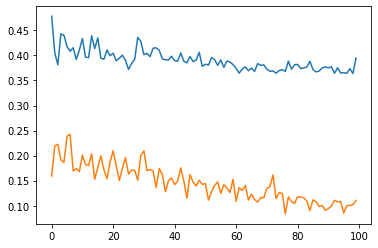

In [161]:
plt.plot(list(range(len(train_losses_cnn))), train_losses_cnn)
plt.plot(list(range(len(train_losses_cnn))), train_losses)
plt.show()

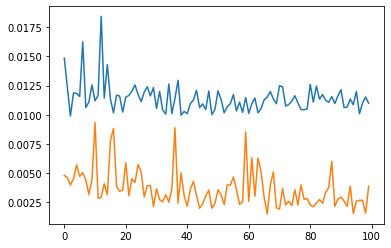

In [162]:
plt.plot(list(range(len(val_losses_cnn))), val_losses_cnn)
plt.plot(list(range(len(val_losses_cnn))), val_losses)
plt.show()

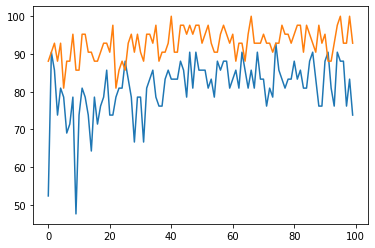

In [163]:
plt.plot(list(range(len(val_accs_cnn))), val_accs_cnn)
plt.plot(list(range(len(val_accs_cnn))), val_accs)
plt.show()

In [ ]:
#Loading best model

XRayModel1 = XRayNet()
# XRayModel1.load_state_dict(torch.load('best.pth'))

if use_cuda:
    XRayModel1.cuda()

In [ ]:
#Testing